# Project-27

# Introduction

This project attempts to investigate crimes in Vancouver, Canada. The dataset used is taken from the Vancouver Police Department from the years 2022 to 2023 of the neighbourhoods Hastings-Sunrise and West Point Grey. These neighbourhoods were chosen as West Point Grey is towards the west of Vancouver and the other is towards the east and neighbourhoods too close may yield similar results.

We want to answer the following question:

**Is there a significant difference between the proportion of violent crimes (homicides and offences against another person) within the past two years between two different neighbourhoods, specifically, Hastings-Sunrise and West Point Grey?**


The columns in this dataset contain the following columns:
1. ``Type``: of crime
2. ``Year``
3. ``Month``
4. ``Day``
5. ``Hour``
6. ``Minute``
7. ``Hundred_Block`` (generalized location of the crime)
8. ``Neighbourhood``
9. ``X``: coordinate
10. ``Y``: coordinate

The type of crimes recorded includes:
1. ``BNE Commercial``: (Commercial Break and Enter)
2. ``BNE Residential/Other``
3. ``Vehicle Collision or Pedestrian Struck (with Fatality)``
4. ``Vehicle Collision or Pedestrian Struck (with Injury)``
5. ``Homicide``
6. ``Mischief``
7. ``Offence Against a Person``
8. ``Other Theft``
9. ``Theft from Vehicle``
10. ``Theft of Vehicle``
11. ``Theft of Bicycle``

# Preliminary Results


## Required Packages

In [1]:
library(tidyverse)
library(base)
library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Reading data from the web

In [2]:
hastings_2023 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_Hastings-Sunrise_2023.csv")
hastings_2022 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_Hastings-Sunrise_2022.csv")
west_point_grey_2022 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_West%20Point%20Grey_2022.csv")
west_point_grey_2023 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_West%20Point%20Grey_2023.csv")

Rows: 482 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 946 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 238 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this

# Data cleaning and wrangling

## Combining all the datasets into one

In [4]:
crimes <- rbind(hastings_2022, hastings_2023, west_point_grey_2022, west_point_grey_2023)
head(crimes)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Theft from Vehicle,2022,5,16,4,20,11XX NOOTKA ST,Hastings-Sunrise,496992.1,5457928
Theft from Vehicle,2022,10,9,2,0,11XX ROSSLAND ST,Hastings-Sunrise,496691.3,5457991
Theft from Vehicle,2022,4,28,17,0,12XX LILLOOET ST,Hastings-Sunrise,497174.1,5457852
Theft from Vehicle,2022,4,17,5,17,12XX ROSSLAND ST,Hastings-Sunrise,496689.9,5457876
Theft from Vehicle,2022,11,8,22,0,12XX SKEENA ST,Hastings-Sunrise,497929.5,5457926
Theft from Vehicle,2022,8,18,20,46,13XX KAMLOOPS ST,Hastings-Sunrise,496017.2,5457788


Table 1: combined crimes dataset

##  Cleaning the dataset

In [5]:
# removing unwanted columns from the dataset
crimes_cleaned <-  crimes |> 
    select(TYPE, YEAR, MONTH, NEIGHBOURHOOD)

head(crimes_cleaned)

TYPE,YEAR,MONTH,NEIGHBOURHOOD
<chr>,<dbl>,<dbl>,<chr>
Theft from Vehicle,2022,5,Hastings-Sunrise
Theft from Vehicle,2022,10,Hastings-Sunrise
Theft from Vehicle,2022,4,Hastings-Sunrise
Theft from Vehicle,2022,4,Hastings-Sunrise
Theft from Vehicle,2022,11,Hastings-Sunrise
Theft from Vehicle,2022,8,Hastings-Sunrise


Table 2: Cleaned crimes dataset

## Plots

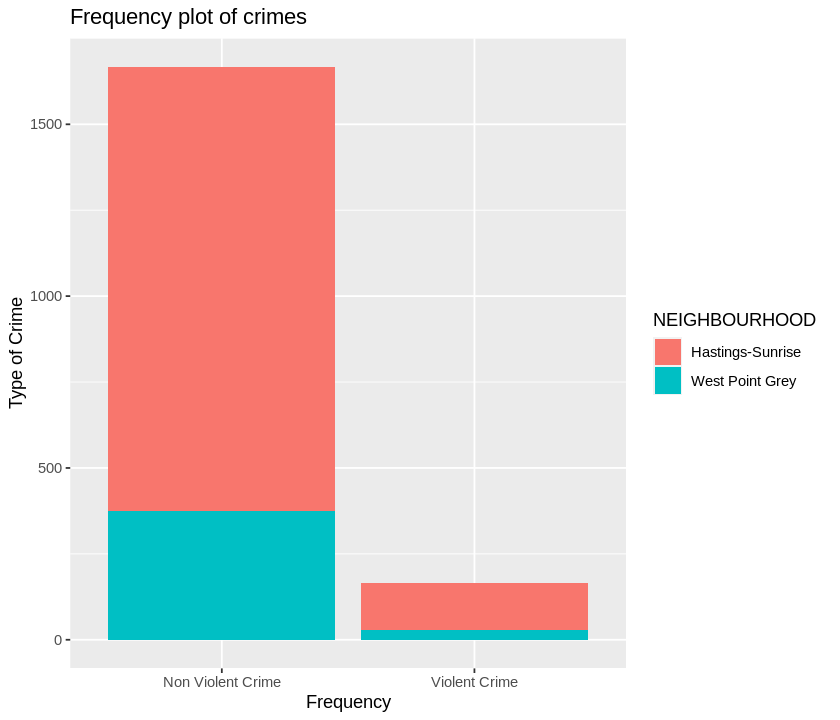

In [6]:
# Adjusting plot sizes
options(repr.plot.width=7, repr.plot.height=6)
vcrimes_vs_allcrimes <- crimes_cleaned

# Grouping "Homicide" and "Offence Against a Person" as the same type
vcrimes_vs_allcrimes$TYPE <- replace(vcrimes_vs_allcrimes$TYPE, vcrimes_vs_allcrimes$TYPE == "Homicide", "Violent Crime")
vcrimes_vs_allcrimes$TYPE <- replace(vcrimes_vs_allcrimes$TYPE, vcrimes_vs_allcrimes$TYPE == "Offence Against a Person", "Violent Crime")

# Grouping all other crimes as "non-violent" crimes
vcrimes_vs_allcrimes$TYPE <- replace(vcrimes_vs_allcrimes$TYPE, vcrimes_vs_allcrimes$TYPE != "Violent Crime", "Non Violent Crime")

# Plotting to see the difference between violent and non violent crimes
vcrimes_vs_allcrimes |>
    ggplot(aes(x = TYPE, fill = NEIGHBOURHOOD)) +
    geom_bar() +
    ggtitle("Frequency plot of crimes") +
    xlab("Frequency") +
    ylab("Type of Crime")

Plot 1: Frequency plot of crimes

In [9]:
# vcrimes <- vcrimes_vs_allcrimes 
    

TYPE,YEAR,MONTH,NEIGHBOURHOOD
<chr>,<dbl>,<dbl>,<chr>
Non Violent Crime,2022,5,Hastings-Sunrise
Non Violent Crime,2022,10,Hastings-Sunrise
Non Violent Crime,2022,4,Hastings-Sunrise
Non Violent Crime,2022,4,Hastings-Sunrise
Non Violent Crime,2022,11,Hastings-Sunrise
Non Violent Crime,2022,8,Hastings-Sunrise


Plot 2: Average monthly crime rate

## Computing the average monthly crime rate of each neighbourhood

In [7]:
# monthly_average_crimes <- violent_crimes |> #counting monthly crimes in both the neighbourhoods
# group_by(MONTH) |> 
# summarise(count = sum(MONTH))

# monthly_average_crimes

Results 1: Average monthly crime rate

## Computing proportion of violent crimes in each neighbourhood

In [8]:
#filtering Offence Against a Person & Homicide crimes as they are considered violent
violent_crimes <- crimes_cleaned |> 
    filter(TYPE == "Offence Against a Person" | TYPE == "Homicide") 

#filtering West Point Grey neighbourhood
vcrimes_in_point_grey_count <- violent_crimes |> 
    filter(NEIGHBOURHOOD == "West Point Grey") |>
    nrow()

#filtering Hastings Sunrise neighbourhood
vcrimes_in_hastings_count <- violent_crimes |> 
    filter(NEIGHBOURHOOD == "Hastings-Sunrise") |>
    nrow()

crimes_in_point_grey_count <- crimes |>
    nrow()

crimes_in_hastings_count <- crimes |>
    nrow()

prop_vcrimes_point_grey <- vcrimes_in_point_grey_count / crimes_in_point_grey_count
prop_vcrimes_hastings <- vcrimes_in_hastings_count / crimes_in_hastings_count

cat("Proportion of violent crimes in West Point Grey from our sample: ", prop_vcrimes_point_grey)
cat("\nProportion of violent crimes in Hastings Sunrise from our sample: ", prop_vcrimes_hastings)

Proportion of violent crimes in West Point Grey from our sample:  0.01583834
Proportion of violent crimes in Hastings Sunrise from our sample:  0.0737302

Results 2: Proportion of violent crimes from our sample

## Compute estimates of the parameter you identified across your groups. Present this in a table. If relevant, include these estimates in your plot.

# Methods: Plan

## Analysis of preliminary exploration

### What do you expect to find?



### What future questions could this lead to?

### What impact could such findings have?

# References